In [309]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt
from scipy.signal import hilbert
import numpy as np
from sklearn.cluster import KMeans
from scipy.signal import savgol_filter

DATA_LENGTH = 200
NUM_PULSES = 35

In [310]:
ruth_achilles_cuff_file_names = [
    "logs/trial_1_7_16/cuff_data_trial_1_run_1_ruth.txt", 
    "logs/trial_1_7_16/cuff_data_trial_1_run_3_ruth.txt", 
    "logs/trial_1_7_16/cuff_data_trial_1_run_4_ruth.txt",  
    "logs/trial_1_7_16/cuff_data_trial_1_run_5_ruth.txt"
]
ruth_achilles_hammer_file_names = [
    "logs/trial_1_7_16/hammer_data_trial_1_run_1_ruth.txt", 
    "logs/trial_1_7_16/hammer_data_trial_1_run_3_ruth.txt", 
    "logs/trial_1_7_16/hammer_data_trial_1_run_4_ruth.txt",  
    "logs/trial_1_7_16/hammer_data_trial_1_run_5_ruth.txt"    
]
rachel_achilles_cuff_file_names = [
    "logs/trial_3_7_16_rachel/cuff_data_trial_3_run_1_rachel.txt", 
    "logs/trial_3_7_16_rachel/cuff_data_trial_3_run_2_rachel.txt", 
    "logs/trial_3_7_16_rachel/cuff_data_trial_3_run_3_rachel.txt",  
    "logs/trial_3_7_16_rachel/cuff_data_trial_3_run_4_rachel.txt",
    "logs/trial_3_7_16_rachel/cuff_data_trial_3_run_4_rachel copy.txt",
    "logs/trial_3_7_16_rachel/cuff_data_trial_3_run_5_rachel.txt",
    "logs/trial_3_7_16_rachel/cuff_data_trial_3_run_6_rachel.txt"
]

rachel_achilles_hammer_file_names = [
    "logs/trial_3_7_16_rachel/hammer_data_trial_3_run_1_rachel.txt", 
    "logs/trial_3_7_16_rachel/hammer_data_trial_3_run_2_rachel.txt", 
    "logs/trial_3_7_16_rachel/hammer_data_trial_3_run_3_rachel.txt", 
    "logs/trial_3_7_16_rachel/hammer_data_trial_3_run_4_rachel.txt", 
    "logs/trial_3_7_16_rachel/hammer_data_trial_3_run_4_rachel copy.txt", 
    "logs/trial_3_7_16_rachel/hammer_data_trial_3_run_5_rachel.txt", 
    "logs/trial_3_7_16_rachel/hammer_data_trial_3_run_6_rachel.txt"
]

chosen_folder_cuff = ruth_achilles_cuff_file_names
chosen_folder_hammer = ruth_achilles_hammer_file_names

cuff_dfs = []   # Each row in array corresponds to 1 cuff txt file
                # Each Cuff txt file df format: 
                # [time1, voltage1,
                #  time2, voltage2, 
                #  etc]
hammer_dfs = [] # Each row in array corresponds to 1 cuff txt file
                # Each Cuff txt file df format: 
                # [time1, voltage1,
                #  time2, voltage2, 
                #  etc]

for file_name in chosen_folder_cuff:
    cuff_dfs.append(pd.read_csv(file_name, skiprows=1, header = None).to_numpy())
for file_name in chosen_folder_hammer:
    hammer_dfs.append(pd.read_csv(file_name, skiprows=1, header = None).to_numpy())

In [311]:
################## Find the indicies of the minimum of each waveform ###############
##### Currently not used

cuff_indiv_waveform_minima_indicies = []
DATA_LENGTH = 200 # Defined in Arduino -- number of points sampled per pulse (pulse_and_read_cuff_v3.ino)

for cuff_df in cuff_dfs:
    this_cuff_indiv_waveform_minima_indicies = []
    for i in range(0, len(cuff_df), DATA_LENGTH):
        single_burst_cuff_waveform = list(cuff_df[:,1])[i: i+DATA_LENGTH]
        index_min = single_burst_cuff_waveform.index(min(single_burst_cuff_waveform))
        this_cuff_indiv_waveform_minima_indicies.append(index_min + i)
        
    cuff_indiv_waveform_minima_indicies.append(this_cuff_indiv_waveform_minima_indicies)

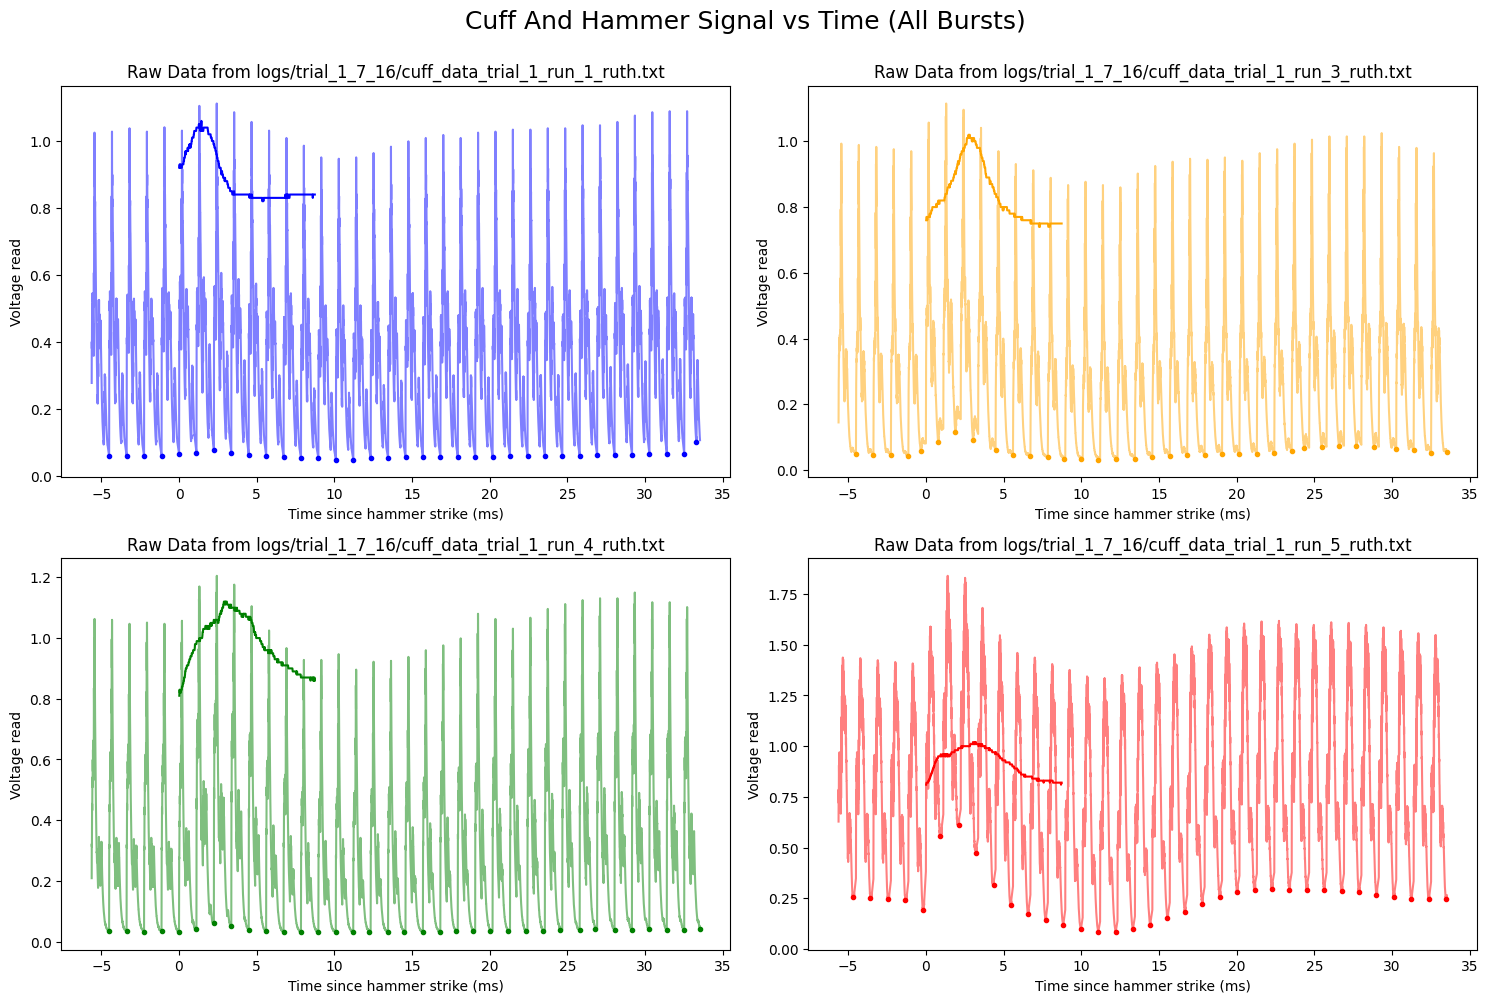

In [312]:
plt.figure(figsize=(15, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Cuff And Hammer Signal vs Time (All Bursts)", fontsize=18, y=0.95)

n = 0
overlay = False
ax_subp = None

color_array = ["blue", "orange", "green", "red", "purple", "brown", 
               "pink", "gray", "olive", "cyan", "turquoise", "magenta", "maroon", "tan"]

for n in range(len(cuff_dfs)):
    df_cuff = cuff_dfs[n]
    df_hammer = hammer_dfs[n]
    waveform_minima = cuff_indiv_waveform_minima_indicies[n]

    # add a new subplot iteratively
    if (not overlay): ax_subp = plt.subplot(4, 2, n+1)
    elif (ax_subp is None): ax_subp = plt.subplot(1, 1, 1)

    ax_subp.plot(df_cuff[:,0], df_cuff[:,1], c=color_array[n % len(cuff_dfs)], alpha = 0.5, label="Cuff")
    ax_subp.plot(df_hammer[:,0], df_hammer[:,1], c=color_array[n % len(cuff_dfs)], label="Hammer")
    for m in waveform_minima:  
        ax_subp.plot(df_cuff[:,0][m], df_cuff[:,1][m], c=color_array[n % len(cuff_dfs)], marker="o", markersize=3)


    # chart formatting
    if (not overlay): ax_subp.set_title("Raw Data from " + str(chosen_folder_cuff[n]))
    ax_subp.set_xlabel("Time since hammer strike (ms)")
    ax_subp.set_ylabel("Voltage read")

if (overlay): plt.legend(chosen_folder_cuff)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

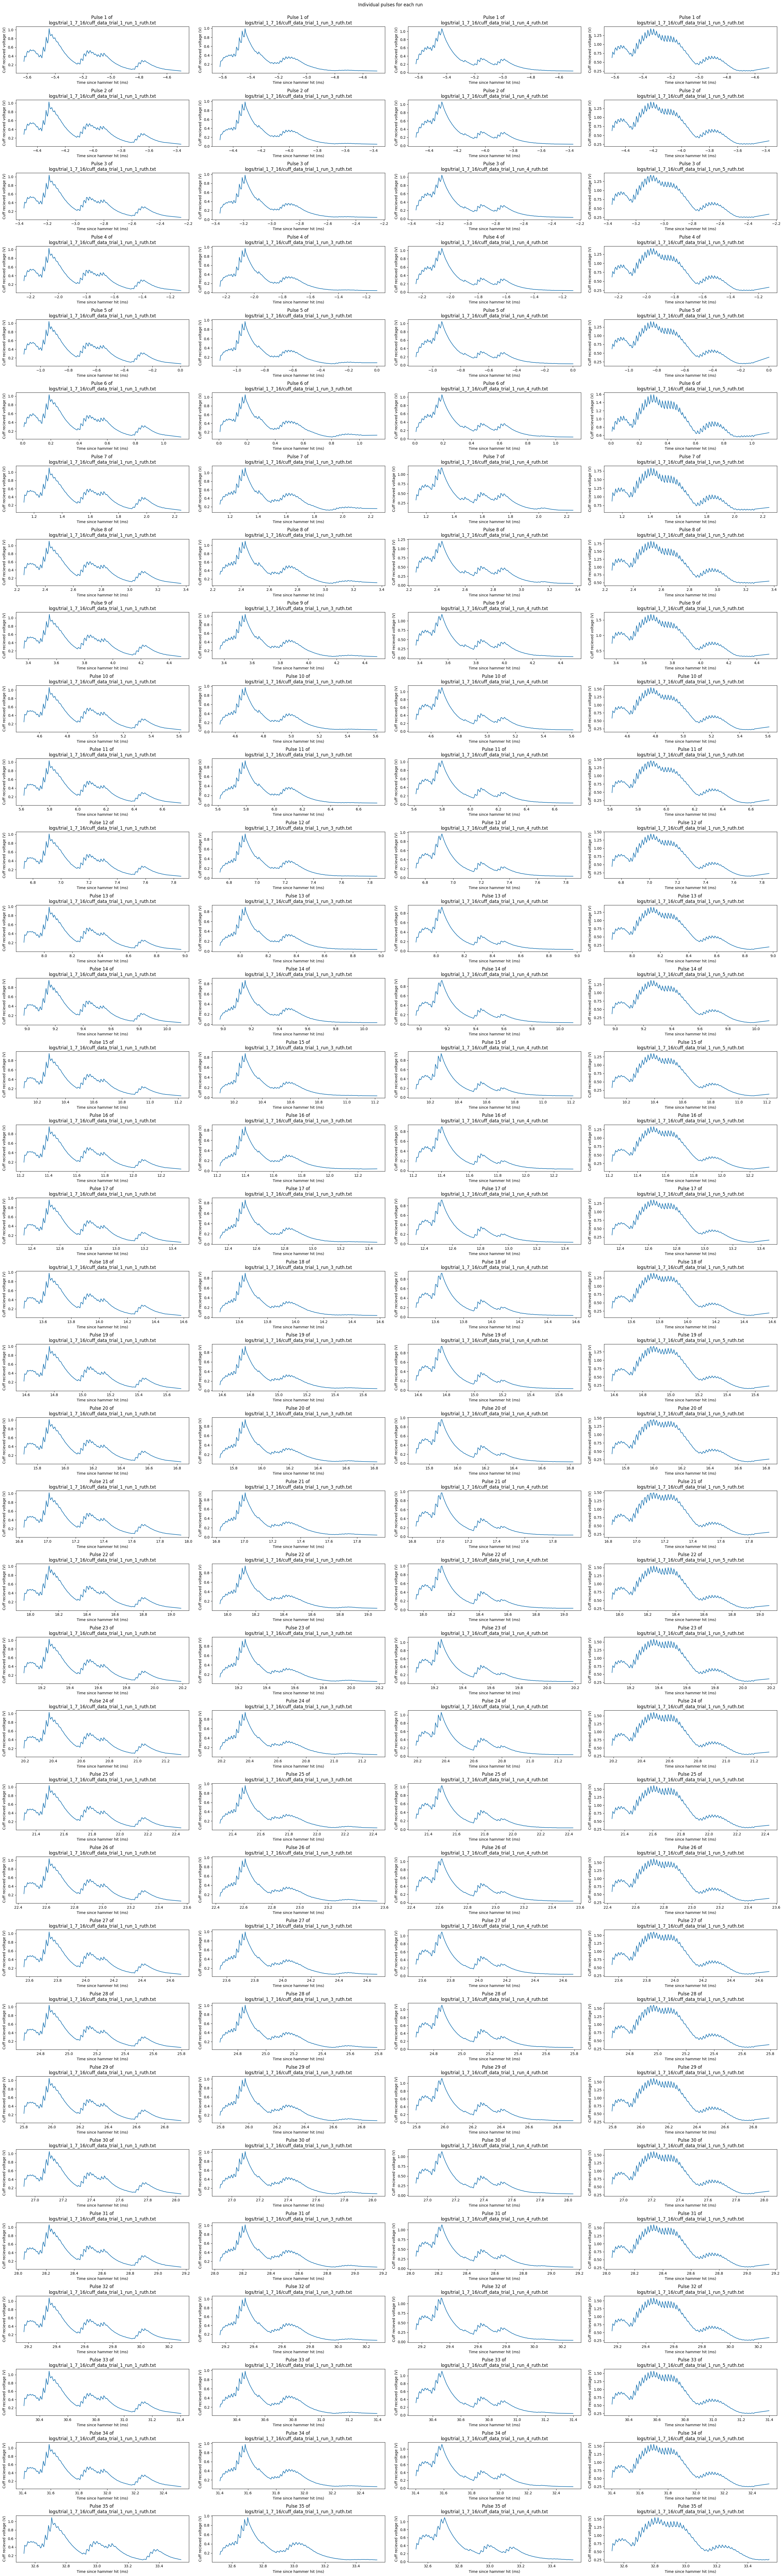

In [313]:
plt.figure(figsize=(30, 100))
plt.subplots_adjust(hspace=1)
plt.suptitle("Individual pulses for each run")

DATA_LENGTH = 200
NUM_PULSES = 35

for n in range(len(cuff_dfs)):
    cuff_df = cuff_dfs[n]
    for p in range(NUM_PULSES):
        
        this_pulse_times = cuff_df[p*DATA_LENGTH:p*DATA_LENGTH + DATA_LENGTH:,0]
        this_pulse_volts = cuff_df[p*DATA_LENGTH:p*DATA_LENGTH + DATA_LENGTH:,1]
        ax_subp = plt.subplot(NUM_PULSES, len(cuff_dfs), n + len(cuff_dfs)*p + 1)
        ax_subp.plot(this_pulse_times, this_pulse_volts)
        ax_subp.set_xlabel("Time since hammer hit (ms)")
        ax_subp.set_ylabel("Cuff recieved voltage (V)")
        ax_subp.set_title(f"Pulse {p+1} of \n{chosen_folder_cuff[n]}")

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [314]:
cuff_df_reshaped_by_burst = []  # Each row in array corresponds to 1 cuff txt file
                                # Cuff txt file df format: 
                                # [ [voltages of pulse 1], [voltages of pulse 2], etc]
num_pulses_cut_off_from_front = 1
num_pulses_cut_off_from_back = 1

for cuff_df in cuff_dfs:
    new_df = cuff_df[:, 1][DATA_LENGTH * num_pulses_cut_off_from_front - 1: 
                           len(cuff_df) - DATA_LENGTH * num_pulses_cut_off_from_back]
    new_df = new_df.reshape(-1, DATA_LENGTH)
    new_df = np.vstack(new_df)
    cuff_df_reshaped_by_burst.append(new_df.astype(float))
    

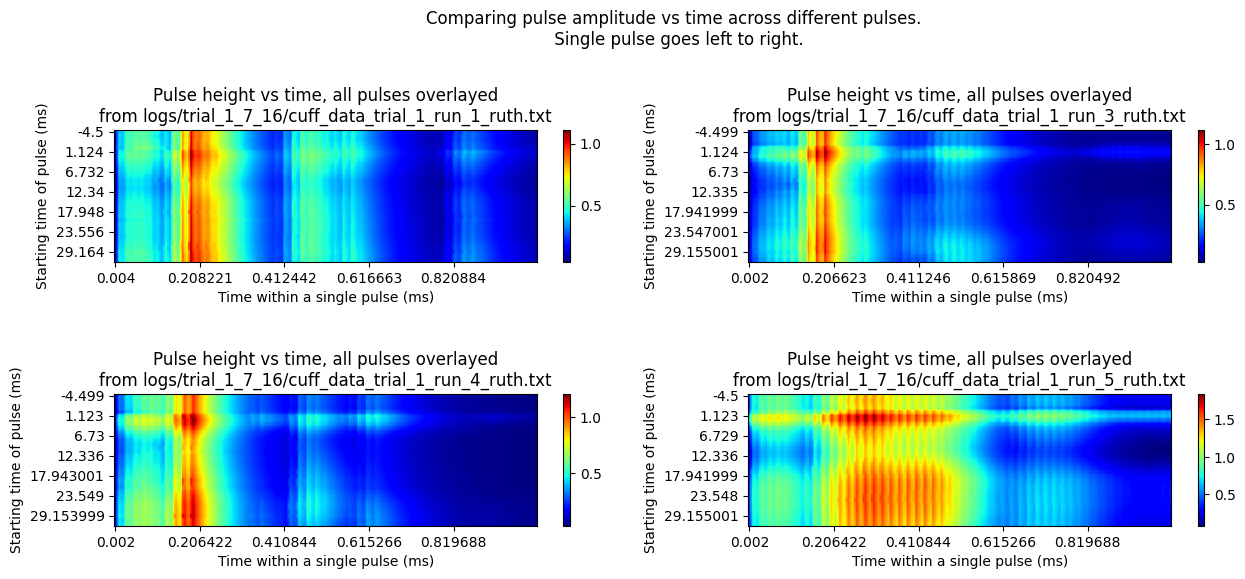

In [315]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=1)
plt.suptitle("Comparing pulse amplitude vs time across different pulses. \n Single pulse goes left to right.")

chosen_pulse_to_examine = 5

for n in range(len(cuff_df_reshaped_by_burst)): # n is iterating over each txt file
    cuff_df = cuff_df_reshaped_by_burst[n]

    # Get every 200th time (so cuff_df_times is 34 long, not 7000 long). 1D array of times.
    cuff_df_times = cuff_dfs[n][:,0][DATA_LENGTH * num_pulses_cut_off_from_front - 1:
                                     len(cuff_dfs[n]) - DATA_LENGTH * num_pulses_cut_off_from_back:
                                     DATA_LENGTH]
    
    chosen_pulse_times = cuff_dfs[n][:,0][chosen_pulse_to_examine*DATA_LENGTH - 1: 
                                          chosen_pulse_to_examine*DATA_LENGTH + DATA_LENGTH - 1]

    # Plot [ [voltages of pulse 1]
    #        [voltages of pulse 2] 
    #        ... etc ]
    ax_subp = plt.subplot(4, 2, n + 1)  # 4x2 grid, current plot position is n+1
    im1 = ax_subp.imshow(cuff_df, aspect='auto', cmap='jet')
    plt.colorbar(im1, ax=ax_subp)
    
    x_ticks = np.arange(0, DATA_LENGTH, 40)
    y_ticks = np.arange(0, NUM_PULSES, 5)
    ax_subp.set_xticks(ticks=x_ticks, labels=chosen_pulse_times[x_ticks])
    ax_subp.set_yticks(ticks=y_ticks, labels=cuff_df_times[y_ticks])
    ax_subp.set_xlabel("Time within a single pulse (ms)")
    ax_subp.set_ylabel("Starting time of pulse (ms)")
    ax_subp.set_title(f"Pulse height vs time, all pulses overlayed\nfrom {chosen_folder_cuff[n]}")

plt.show()

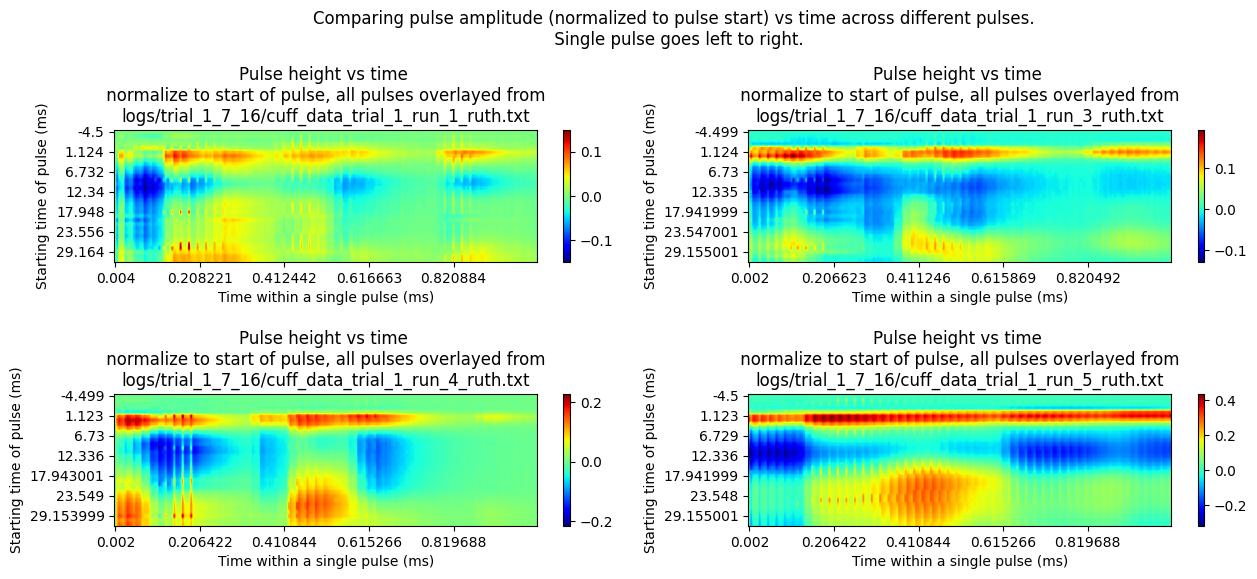

In [316]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=1)
plt.suptitle("Comparing pulse amplitude (normalized to pulse start) vs time across different pulses. \n Single pulse goes left to right.")

chosen_pulse_to_examine = 5

for n in range(len(cuff_df_reshaped_by_burst)): # n is iterating over each txt file
    cuff_df = cuff_df_reshaped_by_burst[n]

    # Get every 200th time (so cuff_df_times is 34 long, not 7000 long). 1D array of times.
    cuff_df_times = cuff_dfs[n][:,0][DATA_LENGTH * num_pulses_cut_off_from_front - 1:
                                     len(cuff_dfs[n]) - DATA_LENGTH * num_pulses_cut_off_from_back:
                                     DATA_LENGTH]
    
    chosen_pulse_times = cuff_dfs[n][:,0][chosen_pulse_to_examine*DATA_LENGTH - 1: 
                                          chosen_pulse_to_examine*DATA_LENGTH + DATA_LENGTH - 1]

    # Plot [ [voltages of pulse 1]
    #        [voltages of pulse 2] 
    #        ... etc ]
    # but this time adjusted for start time
    ax_subp = plt.subplot(4, 2, n + 1)  # 4x2 grid, current plot position is n+1
    im1 = ax_subp.imshow(cuff_df  - cuff_df[0, :], aspect='auto', cmap='jet')
    plt.colorbar(im1, ax=ax_subp)
    
    x_ticks = np.arange(0, DATA_LENGTH, 40)
    y_ticks = np.arange(0, NUM_PULSES, 5)
    ax_subp.set_xticks(ticks=x_ticks, labels=chosen_pulse_times[x_ticks])
    ax_subp.set_yticks(ticks=y_ticks, labels=cuff_df_times[y_ticks])
    ax_subp.set_xlabel("Time within a single pulse (ms)")
    ax_subp.set_ylabel("Starting time of pulse (ms)")
    ax_subp.set_title(f"Pulse height vs time \n normalize to start of pulse, all pulses overlayed from \n{chosen_folder_cuff[n]}")

plt.show()

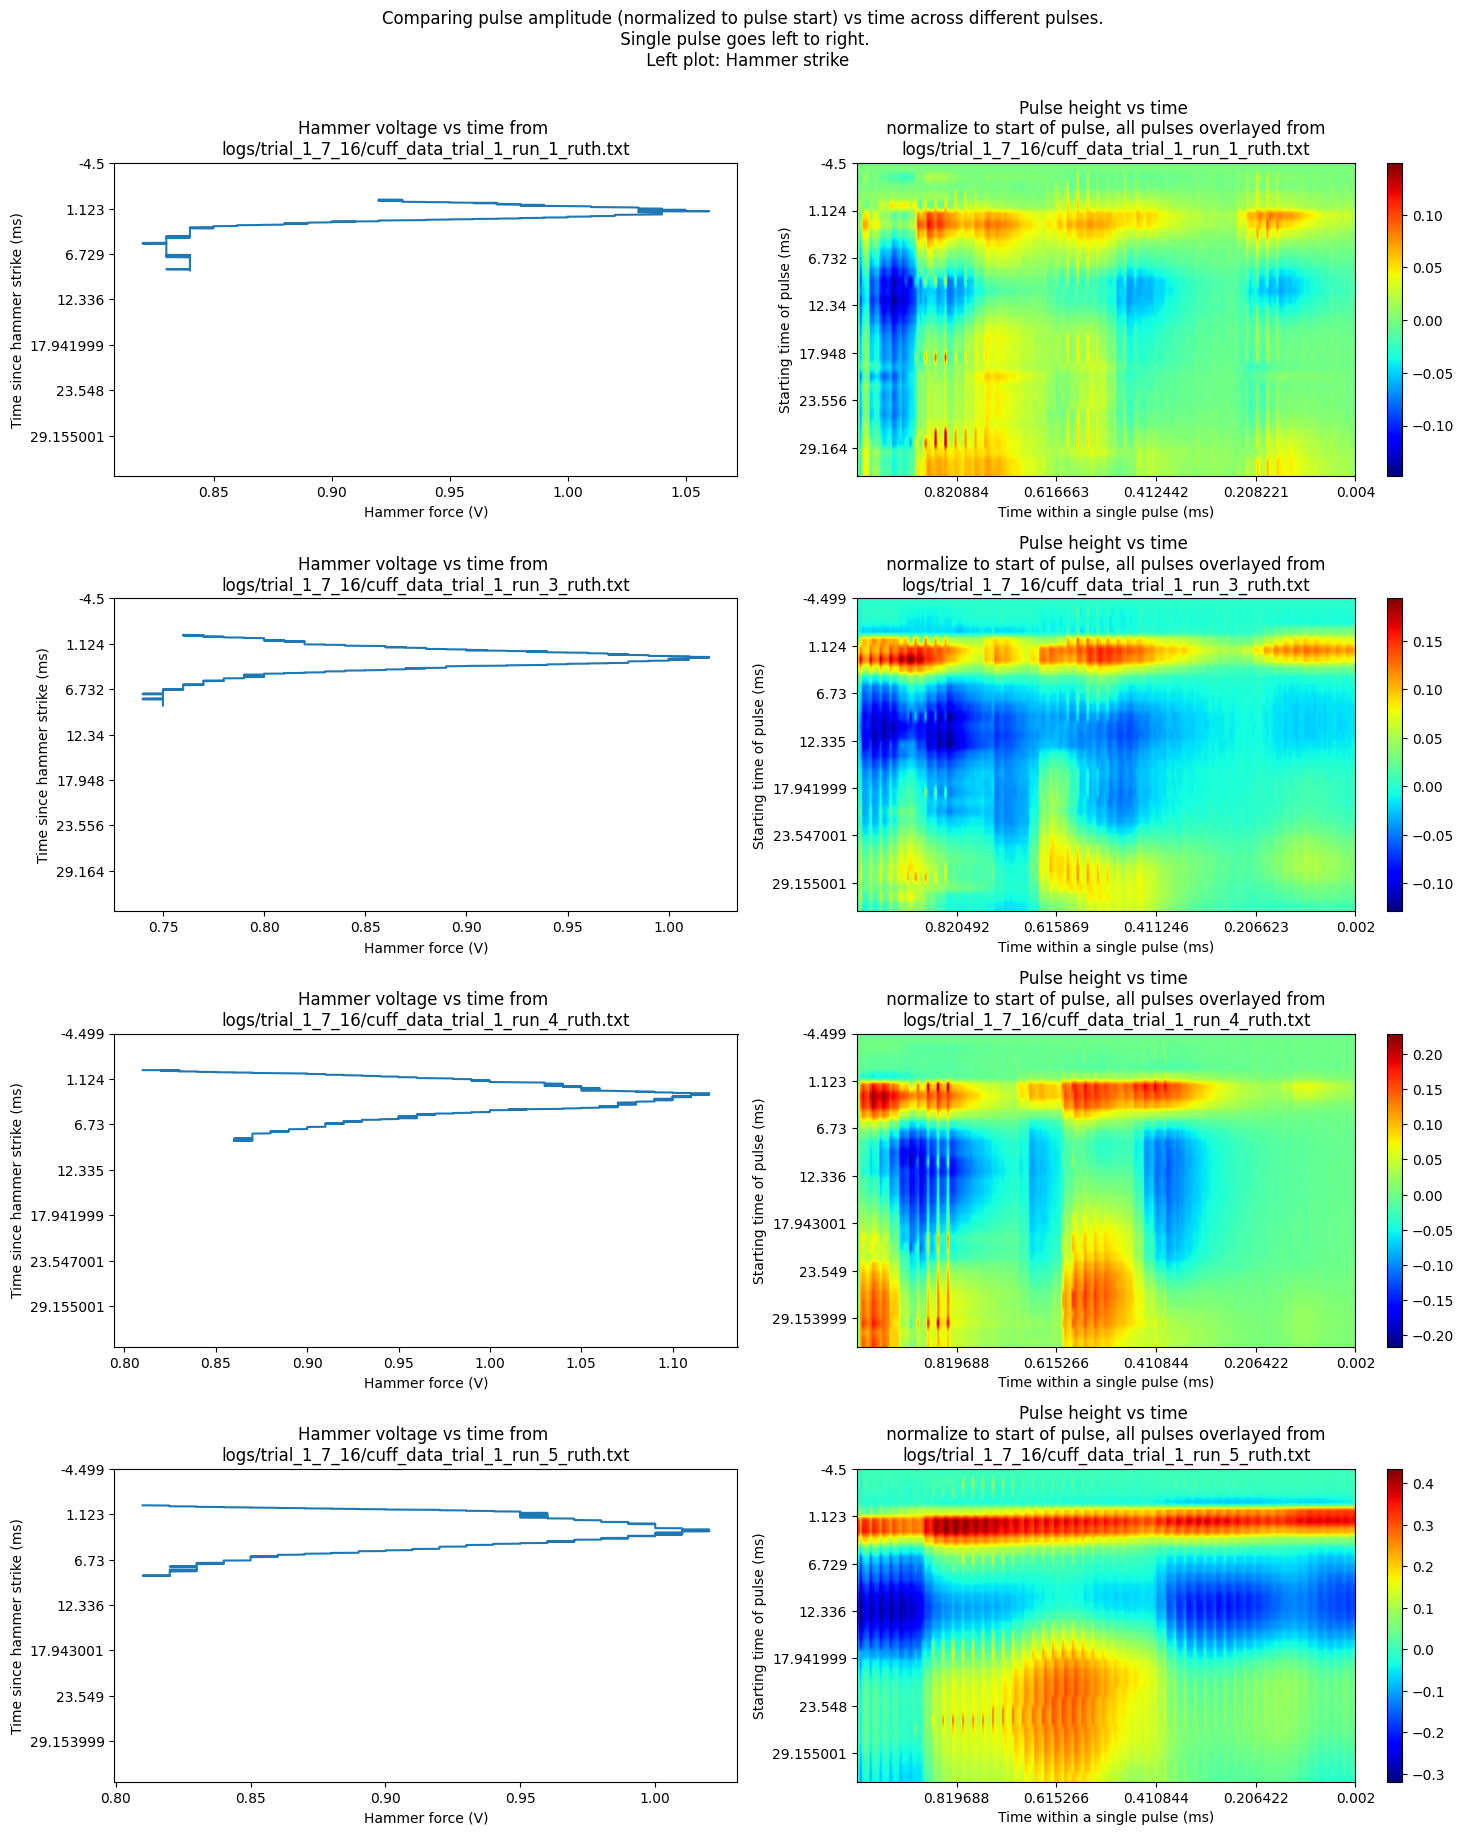

In [317]:
plt.figure(figsize=(15, 36))
plt.subplots_adjust(hspace=1)
plt.suptitle("Comparing pulse amplitude (normalized to pulse start) vs time across different pulses. \n Single pulse goes left to right. \n Left plot: Hammer strike")

chosen_pulse_to_examine = 5

for n in range(len(cuff_df_reshaped_by_burst)): # n is iterating over each txt file
    ################################################# Plotting hammer pulse
    hammer_df = hammer_dfs[n]
    ax_subp_hammer = plt.subplot(8, 2, 2*n+1)
    ax_subp_hammer.plot(hammer_df[:,1], hammer_df[:,0]) 
    ax_subp_hammer.set_xlabel("Hammer force (V)")
    ax_subp_hammer.set_ylabel("Time since hammer strike (ms)")
    ax_subp_hammer.set_title(f"Hammer voltage vs time from \n{chosen_folder_cuff[n]}")

    y_ticks = np.arange(0, NUM_PULSES, 5)
    ax_subp_hammer.set_yticks(ticks=cuff_df_times[y_ticks], labels=cuff_df_times[y_ticks])

    y_min, y_max = ax_subp_hammer.get_ylim()
    ax_subp_hammer.set_ylim(y_min, y_max + 5)
    ax_subp_hammer.set_ylim(ax_subp_hammer.get_ylim()[::-1])    # have to flip upside down some reason?

    ################################################# Plotting cuff heat map (copied from above cells)
    cuff_df = cuff_df_reshaped_by_burst[n]

    # Get every 200th time (so cuff_df_times is 34 long, not 7000 long). 1D array of times.
    cuff_df_times = cuff_dfs[n][:,0][DATA_LENGTH * num_pulses_cut_off_from_front - 1:
                                     len(cuff_dfs[n]) - DATA_LENGTH * num_pulses_cut_off_from_back:
                                     DATA_LENGTH]
    
    chosen_pulse_times = cuff_dfs[n][:,0][chosen_pulse_to_examine*DATA_LENGTH - 1: 
                                          chosen_pulse_to_examine*DATA_LENGTH + DATA_LENGTH - 1]

    # Plot [ [voltages of pulse 1]
    #        [voltages of pulse 2] 
    #        ... etc ]
    # but this time adjusted for start time
    ax_subp = plt.subplot(8, 2, 2*n + 2)  # 4x2 grid, current plot position is n+1
    im1 = ax_subp.imshow(cuff_df  - cuff_df[0, :], aspect='auto', cmap='jet',                          
                         extent=(len(cuff_df[0]), 0, len(cuff_df), 0))
    plt.colorbar(im1, ax=ax_subp)
    
    x_ticks = np.arange(0, DATA_LENGTH, 40)
    y_ticks = np.arange(0, NUM_PULSES, 5)
    ax_subp.set_xticks(ticks=x_ticks, labels=chosen_pulse_times[x_ticks])
    ax_subp.set_yticks(ticks=y_ticks, labels=cuff_df_times[y_ticks])
    ax_subp.set_xlabel("Time within a single pulse (ms)")
    ax_subp.set_ylabel("Starting time of pulse (ms)")
    ax_subp.set_title(f"Pulse height vs time \n normalize to start of pulse, all pulses overlayed from \n{chosen_folder_cuff[n]}")

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

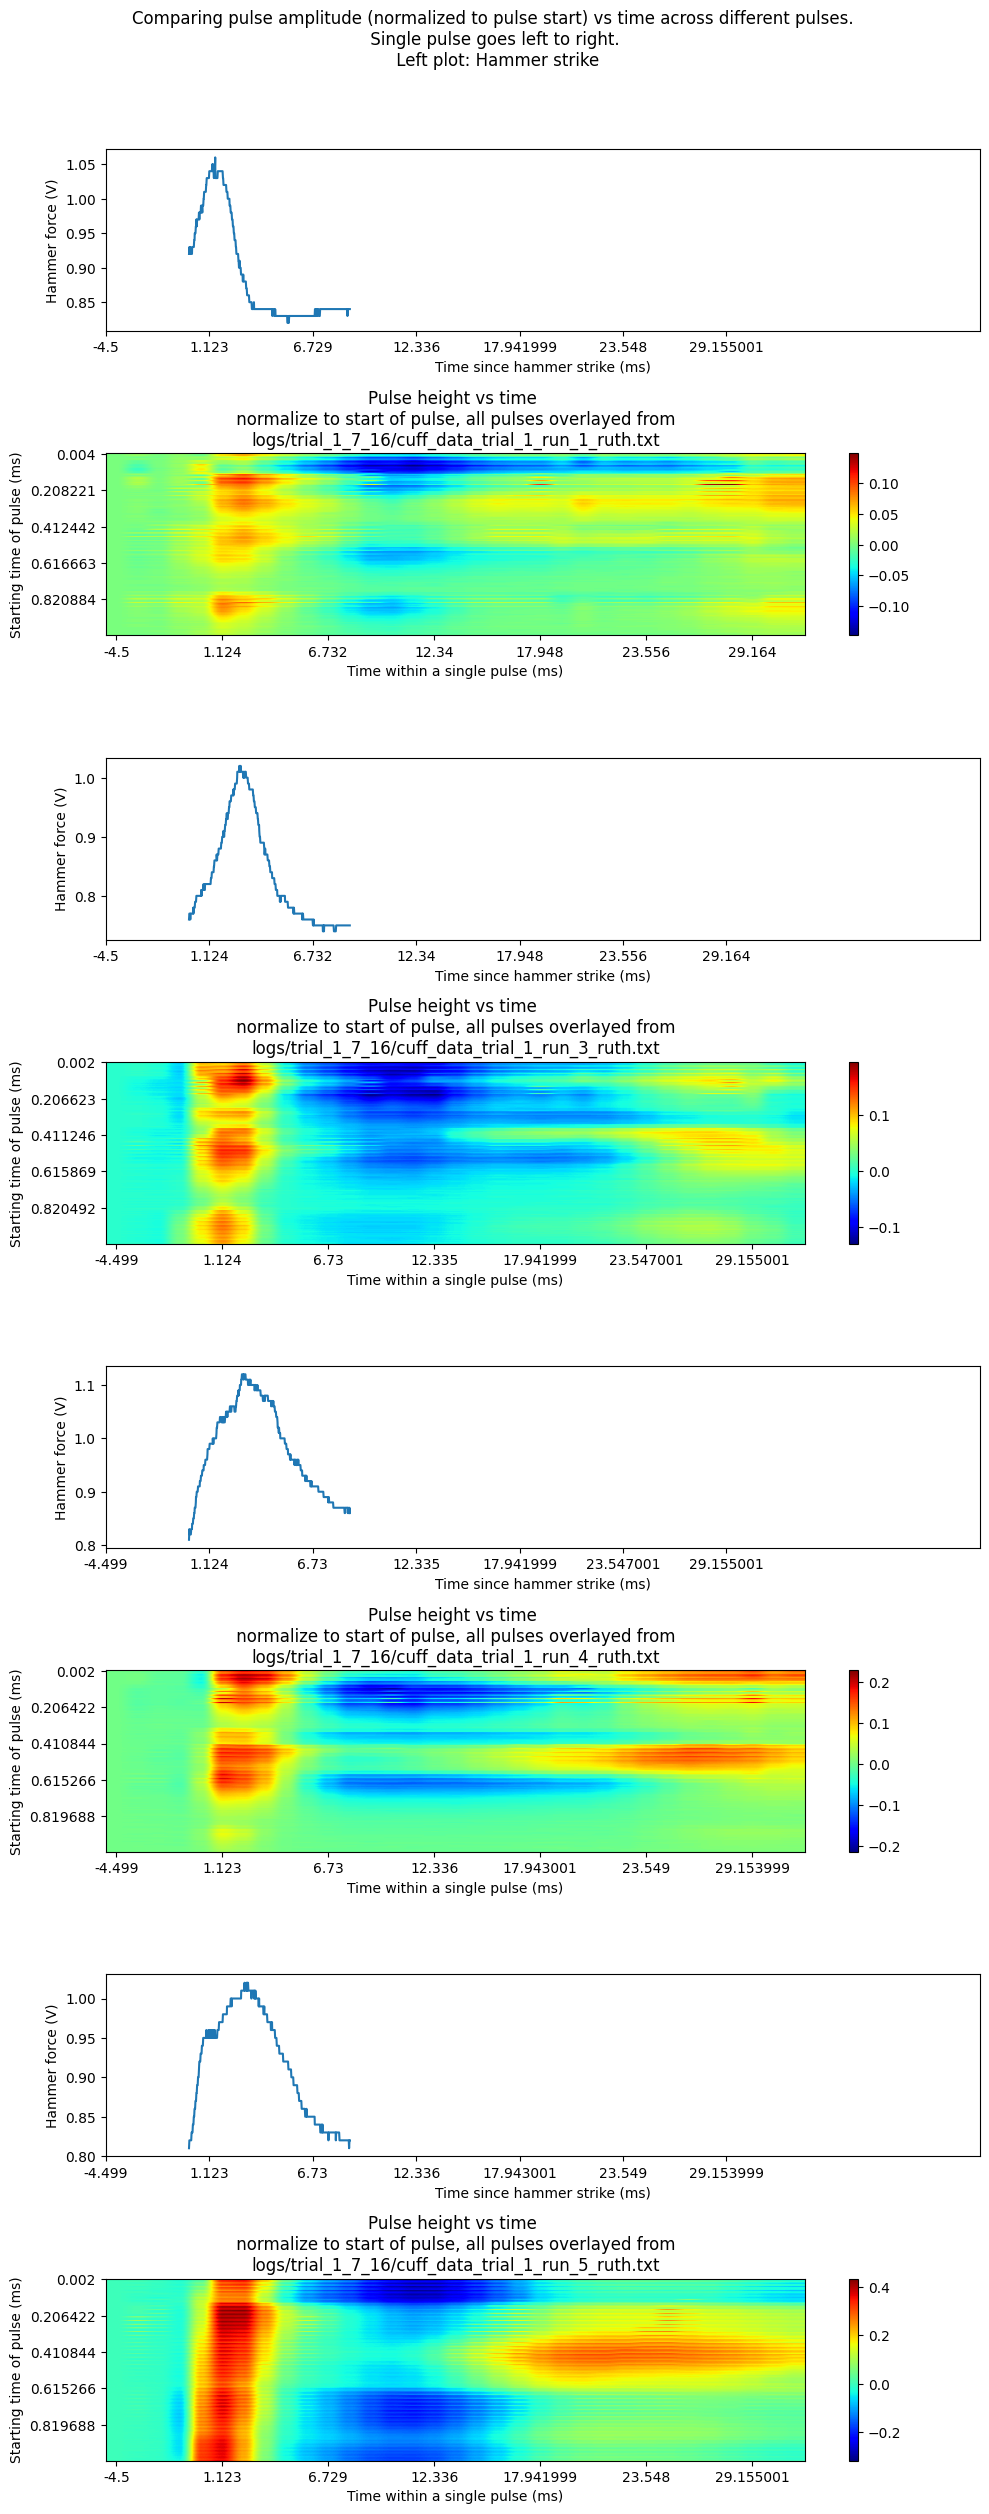

In [318]:
plt.figure(figsize=(10, 50)) 
plt.subplots_adjust(hspace=0.5, wspace=0.4)
plt.suptitle("Comparing pulse amplitude (normalized to pulse start) vs time across different pulses. \n Single pulse goes left to right. \n Left plot: Hammer strike")

chosen_pulse_to_examine = 5

for n in range(len(cuff_df_reshaped_by_burst)): # n is iterating over each txt file

    ################################################# Plotting hammer pulse
    hammer_df = hammer_dfs[n]
    ax_subp_hammer = plt.subplot(16, 1, 2*n+1)
    ax_subp_hammer.plot(hammer_df[:,0], hammer_df[:,1]) 
    ax_subp_hammer.set_ylabel("Hammer force (V)")
    ax_subp_hammer.set_xlabel("Time since hammer strike (ms)")

    # match x_ticks to other plot
    x_ticks = np.arange(0, NUM_PULSES, 5)
    ax_subp_hammer.set_xticks(ticks=cuff_df_times[x_ticks], labels=cuff_df_times[x_ticks])

    # width adj
    x_min, x_max = ax_subp_hammer.get_xlim()
    ax_subp_hammer.set_xlim(x_min, x_max + 5*2.75)

    ################################################# Plotting cuff heat map (copied from above cells)
    cuff_df = cuff_df_reshaped_by_burst[n]

    # Get every 200th time (so cuff_df_times is 34 long, not 7000 long). 1D array of times.
    cuff_df_times = cuff_dfs[n][:,0][DATA_LENGTH * num_pulses_cut_off_from_front - 1:
                                     len(cuff_dfs[n]) - DATA_LENGTH * num_pulses_cut_off_from_back:
                                     DATA_LENGTH]
    
    chosen_pulse_times = cuff_dfs[n][:,0][chosen_pulse_to_examine*DATA_LENGTH - 1: 
                                          chosen_pulse_to_examine*DATA_LENGTH + DATA_LENGTH - 1]

    # Plot [ [voltages of pulse 1]
    #        [voltages of pulse 2] 
    #        ... etc ]
    # but this time adjusted for start time
    ax_subp = plt.subplot(16, 1, 2*n + 2)  # 4x2 grid, current plot position is n+1
    im1 = ax_subp.imshow(np.transpose(cuff_df - cuff_df[0, :]), aspect='auto', cmap='jet')
    plt.colorbar(im1, ax=ax_subp)
    
    y_ticks = np.arange(0, DATA_LENGTH, 40)
    x_ticks = np.arange(0, NUM_PULSES, 5)
    ax_subp.set_yticks(ticks=y_ticks, labels=chosen_pulse_times[y_ticks])
    ax_subp.set_xticks(ticks=x_ticks, labels=cuff_df_times[x_ticks])
    ax_subp.set_xlabel("Time within a single pulse (ms)")
    ax_subp.set_ylabel("Starting time of pulse (ms)")
    ax_subp.set_title(f"Pulse height vs time \n normalize to start of pulse, all pulses overlayed from \n{chosen_folder_cuff[n]}")

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust the rect to leave space for suptitle
plt.show()